In [34]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [65]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [66]:
data1 = pd.read_csv("TS_datasets/sml2010/NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("TS_datasets/sml2010/NEW-DATA-2.T15.txt", sep=' ')

In [67]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [68]:
data1.head()

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,NaN,NaN
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,NaN,NaN
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,NaN,NaN
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,NaN,NaN
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,NaN,NaN


In [69]:
train_size = 3200
val_size = 400
depth = 90
batch_size = 128
prediction_horizon = 1

In [70]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [71]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [72]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [73]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [74]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [75]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [76]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [77]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [78]:
X_train.shape, y_train.shape

((3019, 90, 17), (3019,))

In [79]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [80]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)


In [81]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [82]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)


In [83]:
class ConvRNN(nn.Module):
    def __init__(self, input_dim, timesteps, output_dim, kernel_size1=7, kernel_size2=5, kernel_size3=3, 
                 n_channels1=32, n_channels2=32, n_channels3=32, n_units1=32, n_units2=32, n_units3=32):
        super().__init__()
        self.avg_pool1 = nn.AvgPool1d(2, 2)
        self.avg_pool2 = nn.AvgPool1d(4, 4)
        self.conv11 = nn.Conv1d(input_dim, n_channels1, kernel_size=kernel_size1)
        self.conv12 = nn.Conv1d(n_channels1, n_channels1, kernel_size=kernel_size1)
        self.conv21 = nn.Conv1d(input_dim, n_channels2, kernel_size=kernel_size2)
        self.conv22 = nn.Conv1d(n_channels2, n_channels2, kernel_size=kernel_size2)
        self.conv31 = nn.Conv1d(input_dim, n_channels3, kernel_size=kernel_size3)
        self.conv32 = nn.Conv1d(n_channels3, n_channels3, kernel_size=kernel_size3)
        self.gru1 = nn.GRU(n_channels1, n_units1, batch_first=True)
        self.gru2 = nn.GRU(n_channels2, n_units2, batch_first=True)
        self.gru3 = nn.GRU(n_channels3, n_units3, batch_first=True)
        self.linear1 = nn.Linear(n_units1+n_units2+n_units3, output_dim)
        self.linear2 = nn.Linear(input_dim*timesteps, output_dim)
        self.zp11 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)
        self.zp12 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)
        self.zp21 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)
        self.zp22 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)
        self.zp31 = nn.ConstantPad1d(((kernel_size3-1), 0), 0)
        self.zp32 = nn.ConstantPad1d(((kernel_size3-1), 0), 0)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        # line1
        y1 = self.zp11(x)
        y1 = torch.relu(self.conv11(y1))
        y1 = self.zp12(y1)
        y1 = torch.relu(self.conv12(y1))
        y1 = y1.permute(0, 2, 1)
        out, h1 = self.gru1(y1)
        # line2
        y2 = self.avg_pool1(x)
        y2 = self.zp21(y2)
        y2 = torch.relu(self.conv21(y2))
        y2 = self.zp22(y2)
        y2 = torch.relu(self.conv22(y2))
        y2 = y2.permute(0, 2, 1)
        out, h2 = self.gru2(y2)
        # line3 
        y3 = self.avg_pool2(x)
        y3 = self.zp31(y3)
        y3 = torch.relu(self.conv31(y3))
        y3 = self.zp32(y3)
        y3 = torch.relu(self.conv32(y3))
        y3 = y3.permute(0, 2, 1)
        out, h3 = self.gru3(y3)
        h = torch.cat([h1[-1], h2[-1], h3[-1]], dim=1)
        out1 = self.linear1(h)
        out2 = self.linear2(x.contiguous().view(x.shape[0], -1))
        out = out1 + out2
        return out

In [84]:
model = ConvRNN(X_train.shape[2], X_train.shape[1], 1, n_channels1=128, n_channels2=128, n_channels3=128,
                n_units1=128, n_units2=128, n_units3=128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [85]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [87]:
import time

Saving...
Iter:  0 train:  0.2531142116692684 val:  0.17559220087508934
Iter time:  0.45842283591628075
mse:  14.922988 mae:  3.1001558


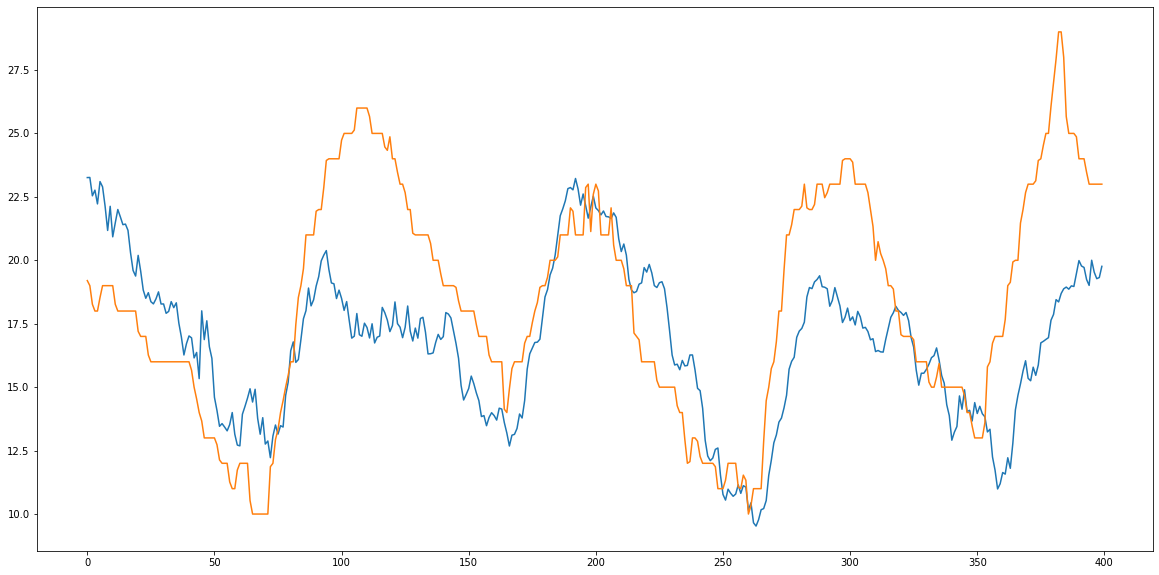

Saving...
Iter:  1 train:  0.1214032450538225 val:  0.1405082549172235
Iter time:  0.46377461217343807
Saving...
Iter:  2 train:  0.09837218786574173 val:  0.12468326106072351
Iter time:  0.42807668168097734
Saving...
Iter:  3 train:  0.08412042093270052 val:  0.11696701463593746
Iter time:  0.4557535098865628
Saving...
Iter:  4 train:  0.07032744079151644 val:  0.1015560595597761
Iter time:  0.46666392032057047
Saving...
Iter:  5 train:  0.05808479541766666 val:  0.0907105383361124
Iter time:  0.465046557597816
Iter:  6 train:  0.05168752186963216 val:  0.09391279123615397
Iter time:  0.4487408557906747
Saving...
Iter:  7 train:  0.04770474557906763 val:  0.08537414828080886
Iter time:  0.41841527353972197
Iter:  8 train:  0.043747356438624097 val:  0.08815996015990785
Iter time:  0.4374502021819353
Saving...
Iter:  9 train:  0.04209650451688117 val:  0.07826668932262072
Iter time:  0.46567431185394526
Iter:  10 train:  0.04104256770824521 val:  0.0822226407889575
Iter time:  0.461762

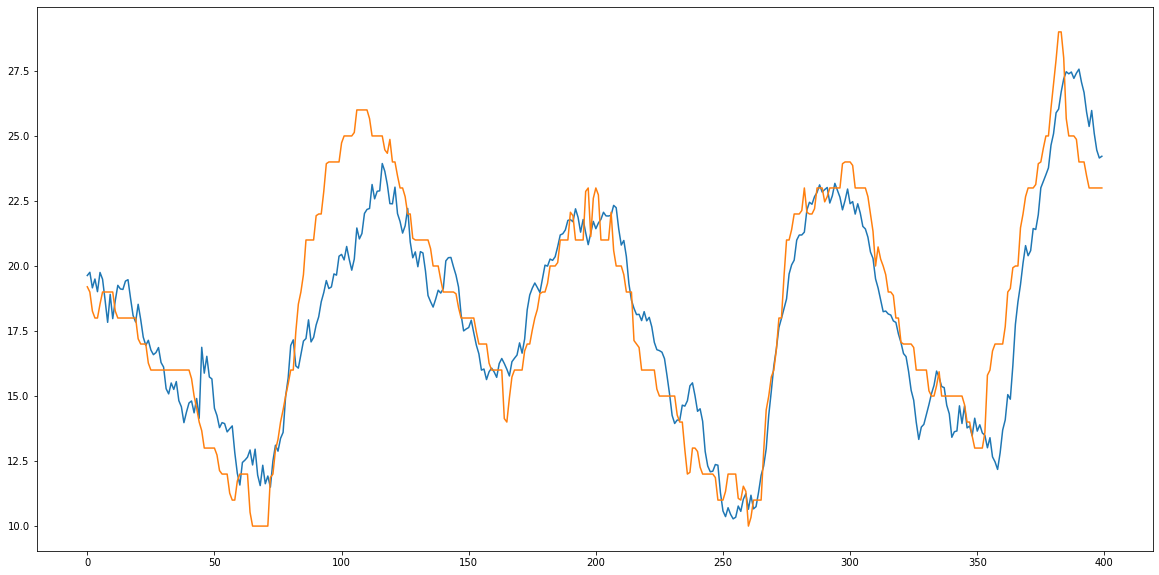

Iter:  11 train:  0.04122370206338064 val:  0.07896014582424965
Iter time:  0.45911291893571615
Iter:  12 train:  0.04052984455031116 val:  0.08162632730304484
Iter time:  0.4599802242591977
Iter:  13 train:  0.04053005545332276 val:  0.08390877958743337
Iter time:  0.4304177472367883
Saving...
Iter:  14 train:  0.03524114140716621 val:  0.07588530848531838
Iter time:  0.4381173150613904
Saving...
Iter:  15 train:  0.034646895026517015 val:  0.07396581238665652
Iter time:  0.4659865824505687
Iter:  16 train:  0.03390430345166622 val:  0.07650577209822941
Iter time:  0.45812427531927824
Saving...
Iter:  17 train:  0.036040288833160655 val:  0.07006330252552742
Iter time:  0.4656978938728571
Iter:  18 train:  0.03192383907748189 val:  0.07873886514556867
Iter time:  0.42545780073851347
Iter:  19 train:  0.037859074774006844 val:  0.07539395982156072
Iter time:  0.45864974055439234
Saving...
Iter:  20 train:  0.031302934588917704 val:  0.06952780329273103
Iter time:  0.44462224189192057
m

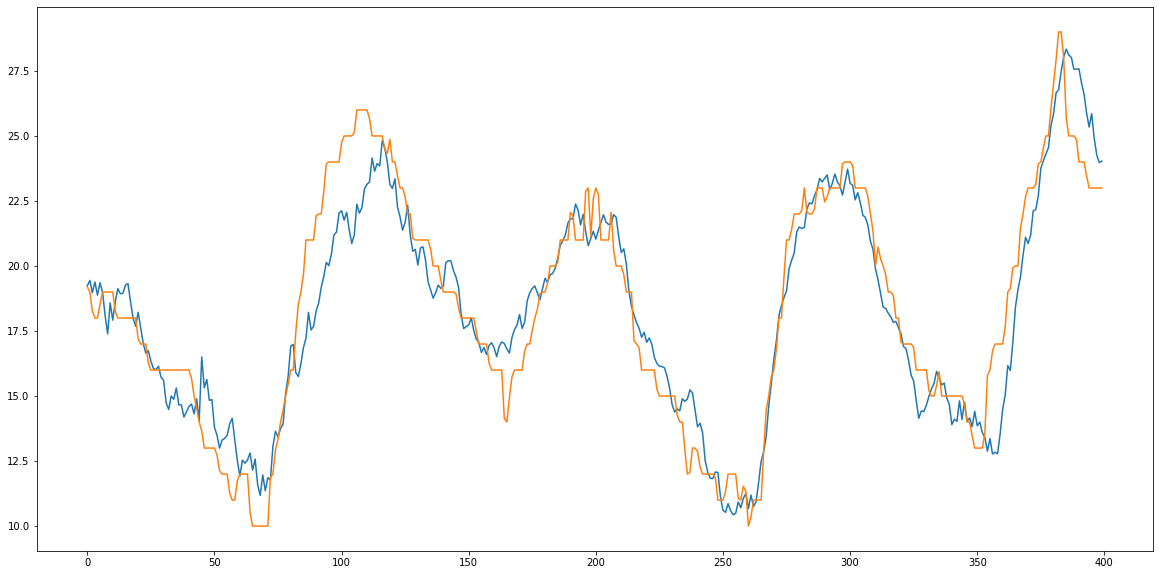

Saving...
Iter:  21 train:  0.029520116481506802 val:  0.06783435678051697
Iter time:  0.4333960050716996
Iter:  22 train:  0.02980815621199358 val:  0.07130128625034579
Iter time:  0.44771211314946413
Saving...
Iter:  23 train:  0.029385576542867796 val:  0.06522352533857492
Iter time:  0.46509827114641666
Iter:  24 train:  0.02781594984765168 val:  0.06720447824779095
Iter time:  0.43778990861028433
Iter:  25 train:  0.027892418987460105 val:  0.0684486639810939
Iter time:  0.4281602445989847
Iter:  26 train:  0.028567496705677205 val:  0.06616600447446679
Iter time:  0.45842006523162127
Saving...
Iter:  27 train:  0.026406829381118484 val:  0.06466757298114843
Iter time:  0.46920530684292316
Iter:  28 train:  0.02694778257225599 val:  0.06769955163946151
Iter time:  0.4636713042855263
Iter:  29 train:  0.028102977476052247 val:  0.07054819472294113
Iter time:  0.4246013769879937
Iter:  30 train:  0.027151590031171114 val:  0.06793217085762476
Iter time:  0.431173725053668
mse:  2.23

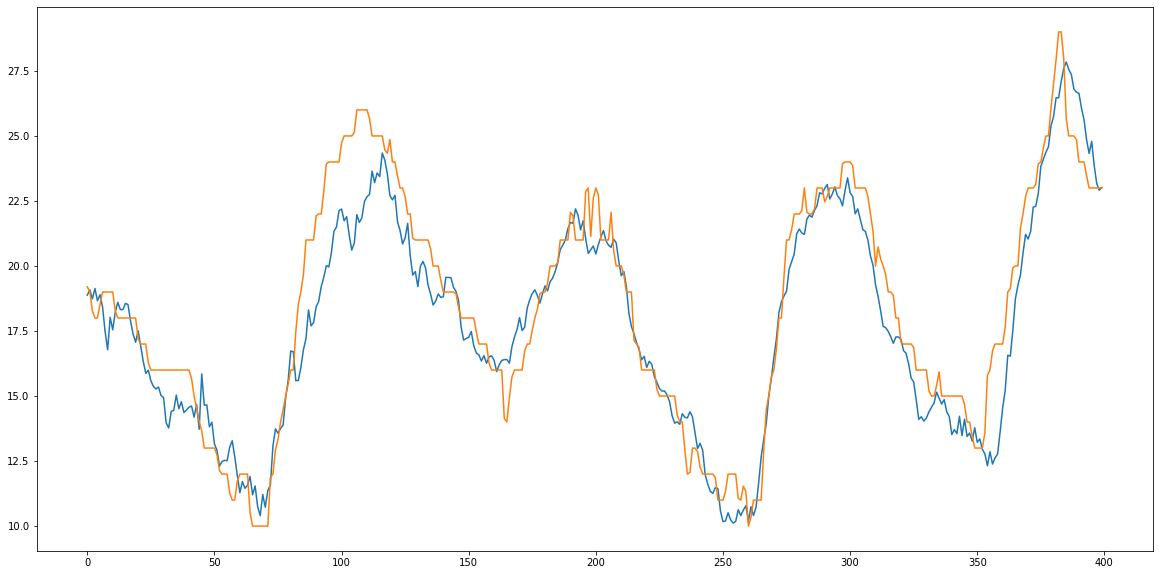

Iter:  31 train:  0.02747664141628856 val:  0.06492037152822902
Iter time:  0.5011840686202049
Iter:  32 train:  0.026829338111186738 val:  0.07021061031646916
Iter time:  0.42076648585498333
Saving...
Iter:  33 train:  0.02666097451652305 val:  0.0611913994436933
Iter time:  0.45825021900236607
Iter:  34 train:  0.02416987731840246 val:  0.06416719882814599
Iter time:  0.4645858919247985
Iter:  35 train:  0.02619395404235519 val:  0.0639995157751563
Iter time:  0.4674700777977705
Iter:  36 train:  0.024773587413657754 val:  0.061523739344749535
Iter time:  0.4552501495927572
Iter:  37 train:  0.0237554933820209 val:  0.06562019937985422
Iter time:  0.4208968933671713
Iter:  38 train:  0.02319321152100986 val:  0.06245134307384513
Iter time:  0.4617397300899029
Iter:  39 train:  0.023338815223514046 val:  0.0614868173150522
Iter time:  0.4624390956014395
Iter:  40 train:  0.021298812115268188 val:  0.06277786061264816
Iter time:  0.46102432254701853
mse:  1.907473 mae:  1.0901986


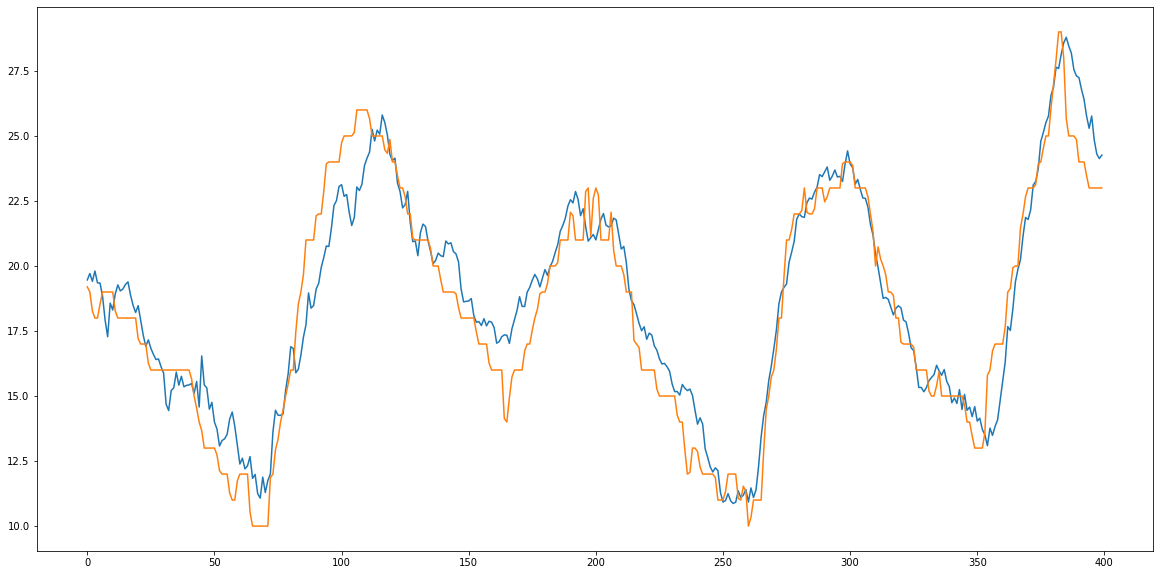

Iter:  41 train:  0.022906042859519308 val:  0.06406745513500257
Iter time:  0.463474752381444
Iter:  42 train:  0.023769805753276318 val:  0.0625256826859676
Iter time:  0.4608449125662446
Saving...
Iter:  43 train:  0.021468981284955207 val:  0.060389171844409485
Iter time:  0.4596122456714511
Iter:  44 train:  0.020065061684725643 val:  0.060882259358551696
Iter time:  0.42065465077757835
Saving...
Iter:  45 train:  0.024645344066712184 val:  0.06035904884200883
Iter time:  0.4666667152196169
Iter:  46 train:  0.02321140890766641 val:  0.060848866095278856
Iter time:  0.4605409614741802
Saving...
Iter:  47 train:  0.021994866058876916 val:  0.06031966245943523
Iter time:  0.4663880169391632
Iter:  48 train:  0.021690419085700883 val:  0.06124674202078189
Iter time:  0.43613577634096146
Iter:  49 train:  0.021183239068331257 val:  0.06215621813221417
Iter time:  0.4325597891584039
Iter:  50 train:  0.018704460208660317 val:  0.06201099785813754
Iter time:  0.45834590308368206
mse:  1

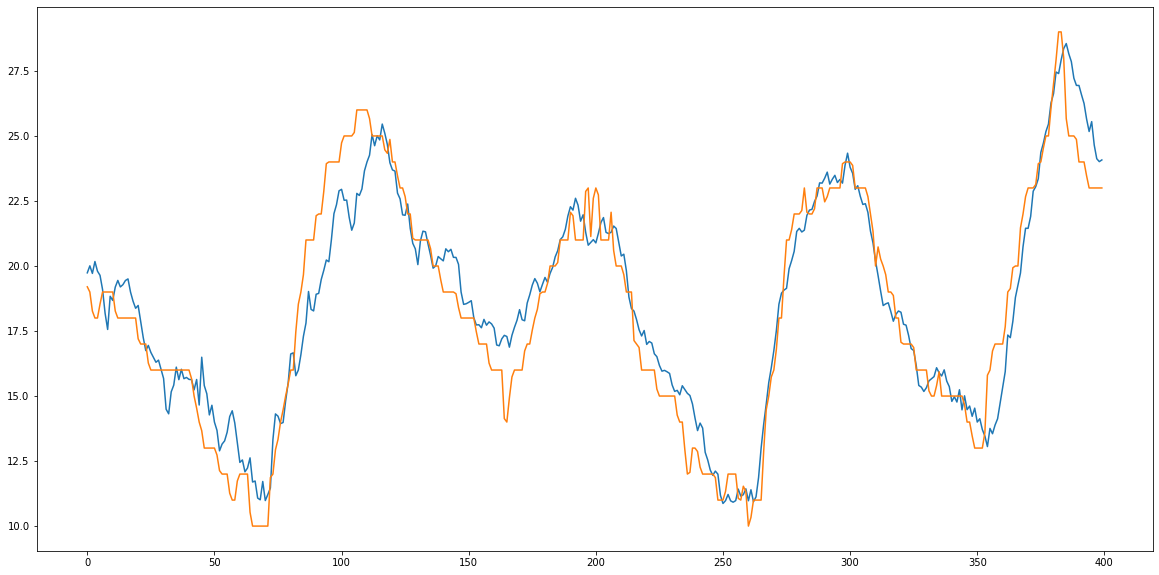

Iter:  51 train:  0.019075949163852485 val:  0.06290688985583497
Iter time:  0.4279069136828184
Iter:  52 train:  0.019698600155002702 val:  0.06221071064725754
Iter time:  0.4568845583125949
Iter:  53 train:  0.0187885047686497 val:  0.060543411217331665
Iter time:  0.4631123198196292
Saving...
Iter:  54 train:  0.019807087646565292 val:  0.05862854973217421
Iter time:  0.4635154418647289
Iter:  55 train:  0.02066562889290708 val:  0.060777920151235405
Iter time:  0.43671903014183044
Iter:  56 train:  0.02141813816500325 val:  0.06234984689552626
Iter time:  0.4294665455818176
Iter:  57 train:  0.018138048335297738 val:  0.06048877943731107
Iter time:  0.46225952357053757
Iter:  58 train:  0.017646246373044308 val:  0.05868004547708793
Iter time:  0.4596464727073908
Iter:  59 train:  0.01829111091834288 val:  0.059611901633434536
Iter time:  0.4616419030353427
Saving...
Iter:  60 train:  0.01758023106831988 val:  0.05831133365180168
Iter time:  0.4404412489384413
mse:  1.6457024 mae: 

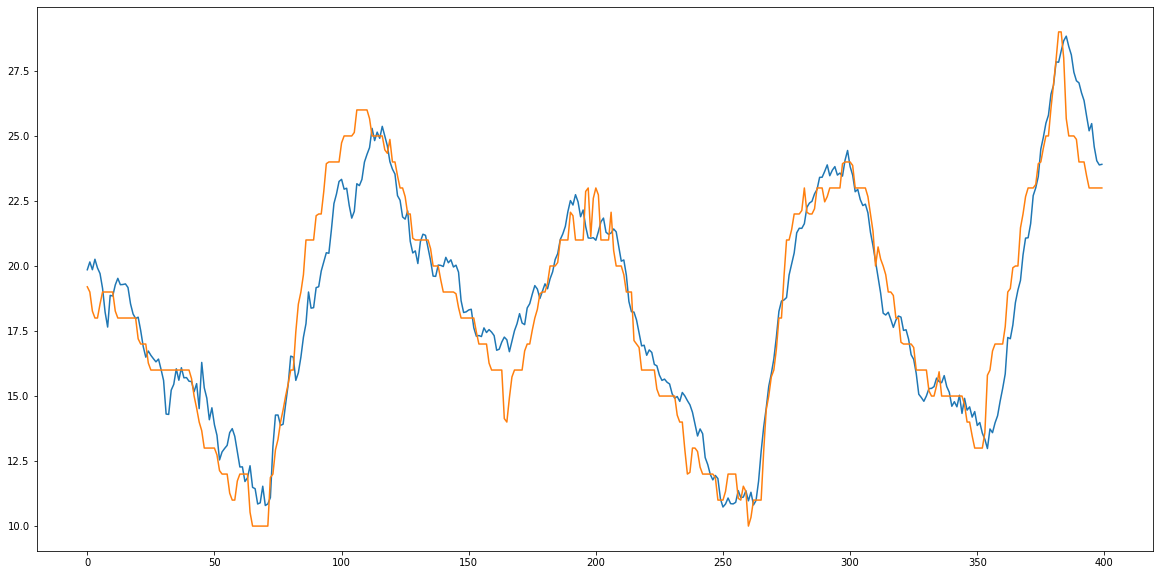

Saving...
Iter:  61 train:  0.016372390736009265 val:  0.05767693137686303
Iter time:  0.4648571303114295
Iter:  62 train:  0.016523880875218815 val:  0.05944540874770704
Iter time:  0.4408627338707447
Iter:  63 train:  0.0182262819509988 val:  0.05939219752766217
Iter time:  0.42665168084204197
Iter:  64 train:  0.020330150148817873 val:  0.06113037433576269
Iter time:  0.46322871651500463
Iter:  65 train:  0.019890018706961318 val:  0.061763047214229046
Iter time:  0.4611458834260702
Iter:  66 train:  0.018421287360684015 val:  0.058957751056965775
Iter time:  0.4642483163625002
Iter:  67 train:  0.01694224094887502 val:  0.05927694876726207
Iter time:  0.4265893194824457
Iter:  68 train:  0.01986830506407322 val:  0.05983498388333142
Iter time:  0.4453686969354749
Iter:  69 train:  0.018522740157700255 val:  0.062404499106279314
Iter time:  0.4636042658239603
Iter:  70 train:  0.016244796877738308 val:  0.058789065351517816
Iter time:  0.4590726653113961
mse:  1.6727786 mae:  1.0132

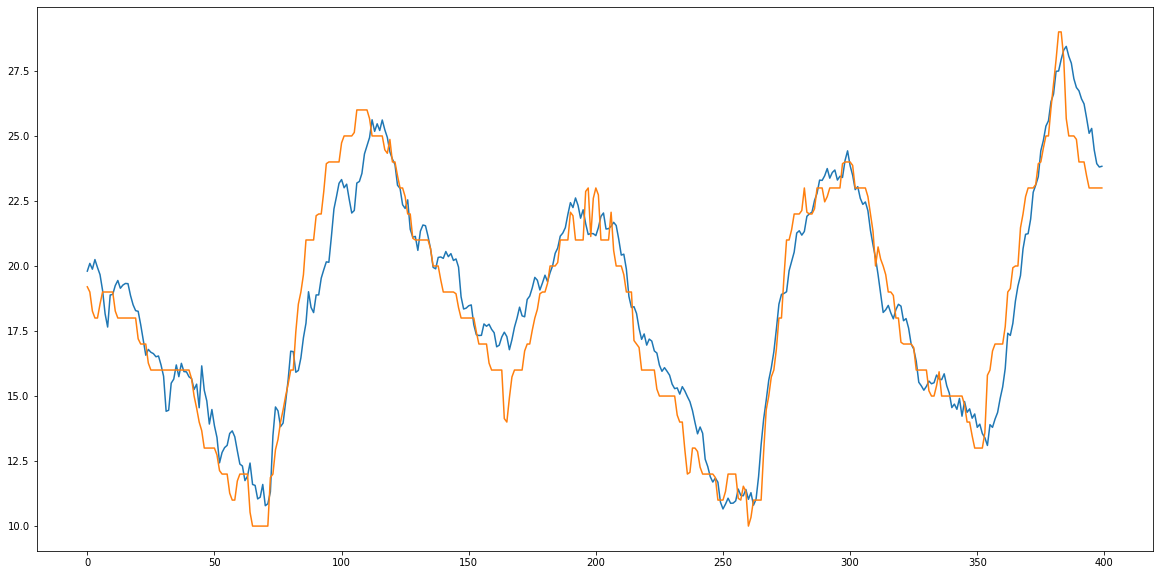

Iter:  71 train:  0.018881815710321367 val:  0.0607873460512371
Iter time:  0.4589096028357744
Iter:  72 train:  0.015927963167177126 val:  0.05991350590478051
Iter time:  0.4575399039313197
Iter:  73 train:  0.016078948074526676 val:  0.05969402771226053
Iter time:  0.4599556475877762
Iter:  74 train:  0.017741151597345097 val:  0.0589768537563945
Iter time:  0.4267557403072715
Iter:  75 train:  0.01590010811529245 val:  0.05912137258644751
Iter time:  0.4428571127355099
Iter:  76 train:  0.016082859860934478 val:  0.059181283702663484
Iter time:  0.45994689874351025
Iter:  77 train:  0.016082405398568613 val:  0.05788609694843191
Iter time:  0.4714123113080859
Iter:  78 train:  0.016333505332243273 val:  0.0581023374082392
Iter time:  0.4504621308296919
Iter:  79 train:  0.01615692720705495 val:  0.059292643927600405
Iter time:  0.4151512337848544
Iter:  80 train:  0.016052003758037385 val:  0.058840081265138615
Iter time:  0.4593952912837267
mse:  1.675683 mae:  1.0104817


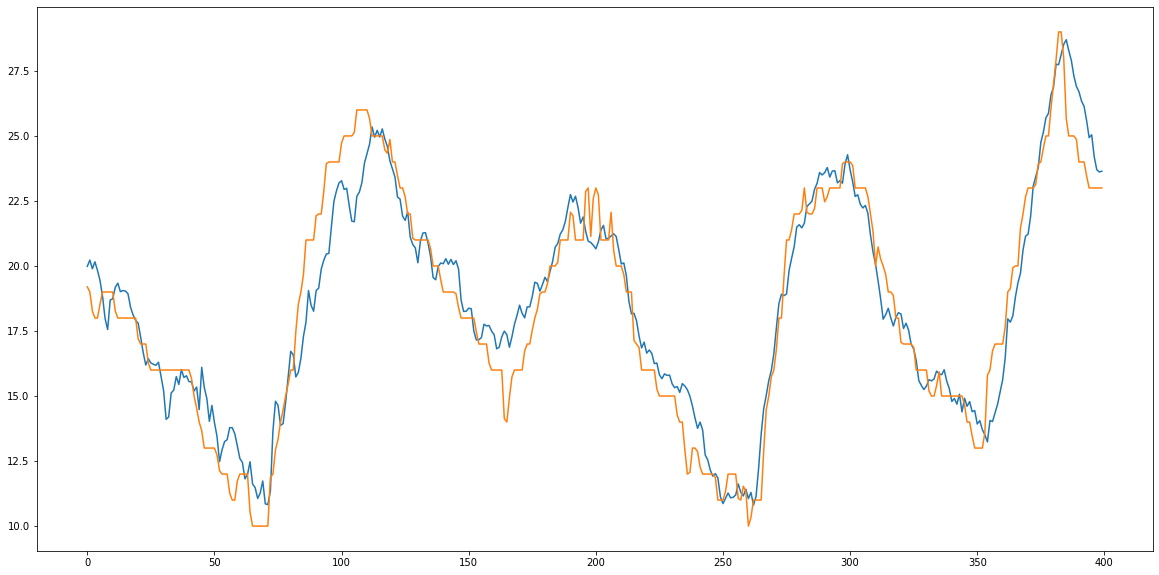

Iter:  81 train:  0.01461507473345615 val:  0.05956807241761877
Iter time:  0.4225330827757716
Saving...
Iter:  82 train:  0.014553135608720999 val:  0.057151715705439504
Iter time:  0.44644841086119413
Saving...
Iter:  83 train:  0.01628421518294276 val:  0.05669106178071271
Iter time:  0.4652814343571663
Iter:  84 train:  0.014192009514595256 val:  0.061858014029389195
Iter time:  0.4601239589974284
Iter:  85 train:  0.01725707111760012 val:  0.06267558757565425
Iter time:  0.4650143291801214
Iter:  86 train:  0.016874514595939524 val:  0.05816669700246264
Iter time:  0.4187555368989706
Iter:  87 train:  0.014797297362823281 val:  0.05898429510603793
Iter time:  0.45537169743329287
Iter:  88 train:  0.015388723400996085 val:  0.06043327749940229
Iter time:  0.46189785189926624
Iter:  89 train:  0.014390771728877918 val:  0.06136248925701039
Iter time:  0.45831777807325125
Iter:  90 train:  0.01447086402118284 val:  0.05730624493885881
Iter time:  0.4384670155122876
mse:  1.5894586 ma

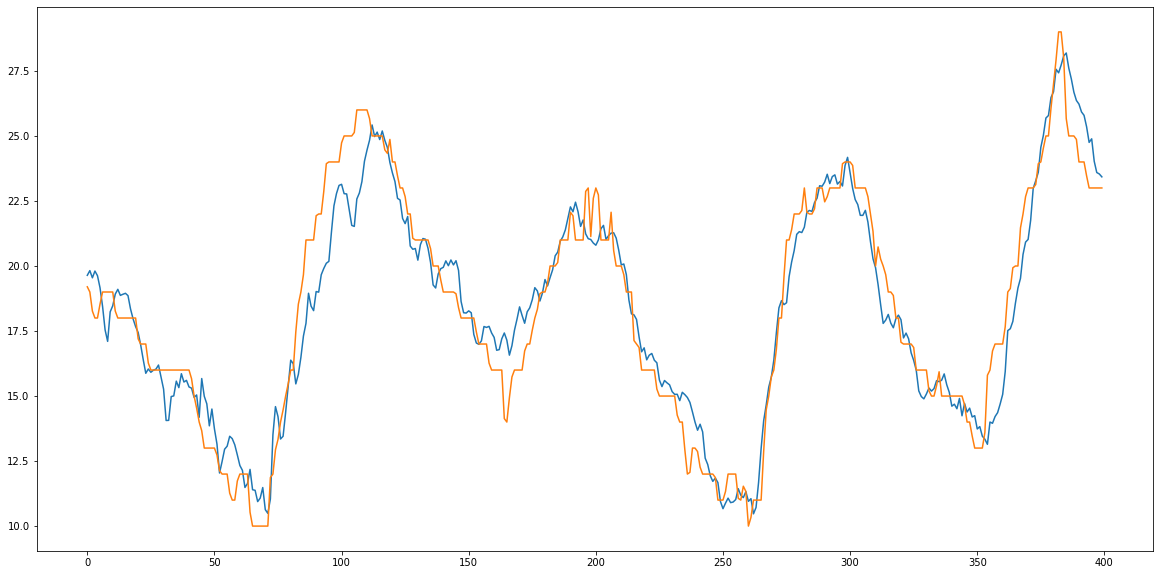

Iter:  91 train:  0.013864599337063688 val:  0.05999151810656233
Iter time:  0.4592383038252592
Saving...
Iter:  92 train:  0.016463459542653228 val:  0.05656068422237665
Iter time:  0.45553044881671667
Iter:  93 train:  0.014864872367516784 val:  0.05769091172890698
Iter time:  0.43454675003886223
Iter:  94 train:  0.014527740729229842 val:  0.05966858980570485
Iter time:  0.45273604802787304
Iter:  95 train:  0.01999263978090285 val:  0.06658262727559615
Iter time:  0.460326973348856
Iter:  96 train:  0.021377863124053237 val:  0.05959080515598273
Iter time:  0.4591688681393862
Iter:  97 train:  0.017138591473268763 val:  0.06248162699893126
Iter time:  0.43461099173873663
Iter:  98 train:  0.014417400385994233 val:  0.05811079561836187
Iter time:  0.4314492354169488
Iter:  99 train:  0.017498167806604535 val:  0.058423714127252585
Iter time:  0.46228194143623114
Iter:  100 train:  0.013246651932586955 val:  0.059126137908002176
Iter time:  0.4606657912954688
mse:  1.6920156 mae:  1.

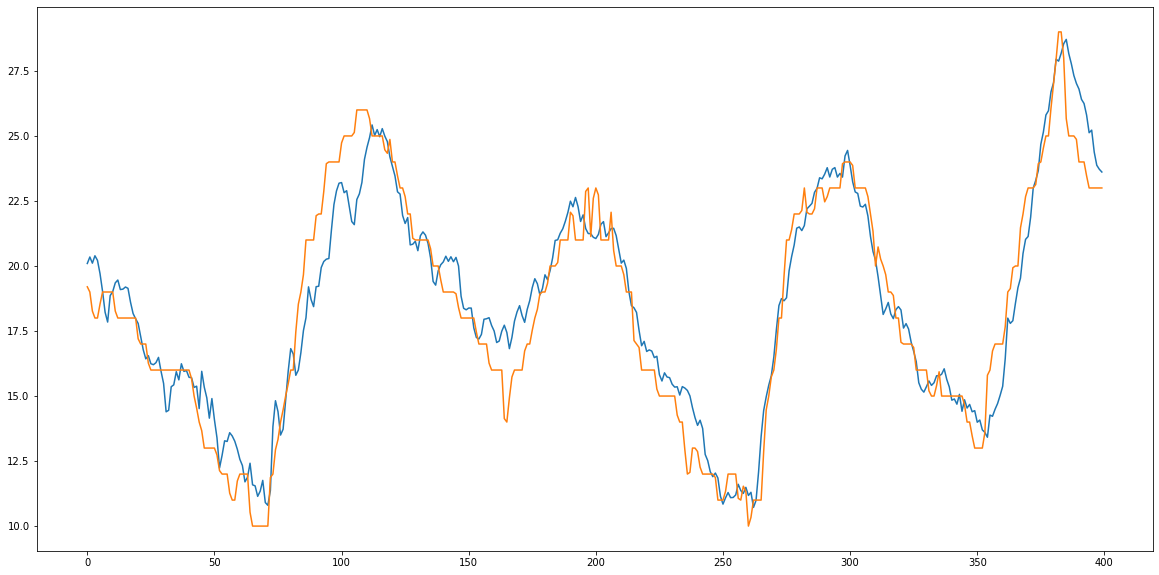

Iter:  101 train:  0.013451001034342464 val:  0.057996043703627126
Iter time:  0.4649379923939705
Iter:  102 train:  0.012215526897859152 val:  0.05791077155161053
Iter time:  0.464859108440578
Iter:  103 train:  0.012649503071501294 val:  0.057730221192420036
Iter time:  0.45900559332221746
Iter:  104 train:  0.012431064368307586 val:  0.05837221928596106
Iter time:  0.42966593988239765
Iter:  105 train:  0.011862114597963044 val:  0.057149096450604925
Iter time:  0.43623577523976564
Iter:  106 train:  0.012442516764404797 val:  0.05908586978265377
Iter time:  0.46047854609787464
Iter:  107 train:  0.014757757857576012 val:  0.05823300957723039
Iter time:  0.4602504363283515
Iter:  108 train:  0.015288433995137593 val:  0.058177933585688096
Iter time:  0.4524575062096119
Iter:  109 train:  0.012259599026030885 val:  0.05843073643848268
Iter time:  0.4170949989929795
Saving...
Iter:  110 train:  0.015063623847726413 val:  0.05599943421814562
Iter time:  0.46751270815730095
mse:  1.5177

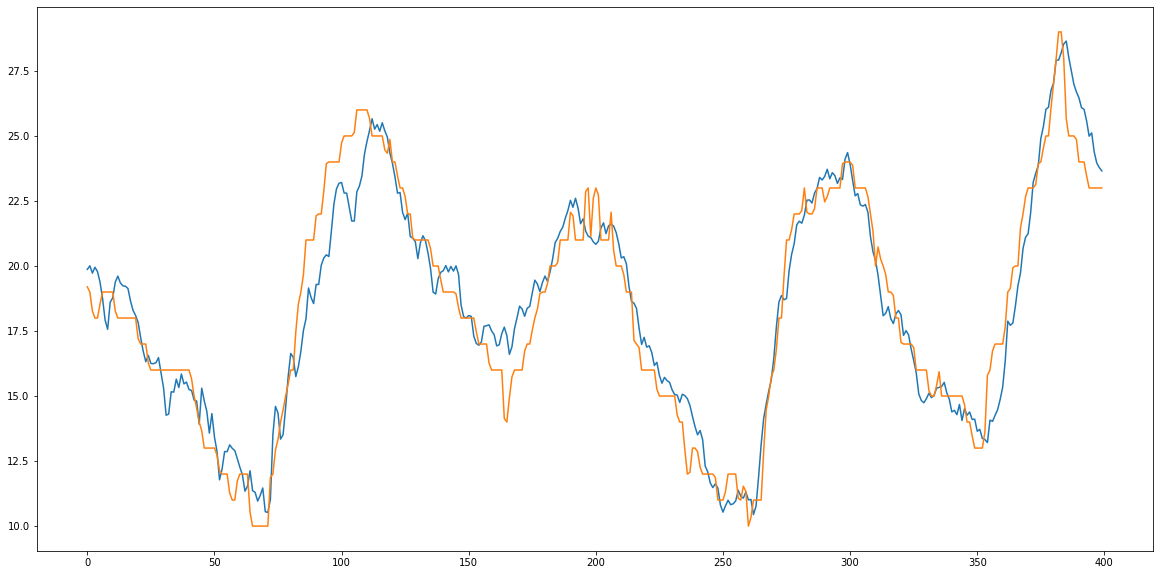

Iter:  111 train:  0.016157761210203746 val:  0.05967238077437301
Iter time:  0.4338107379153371
Iter:  112 train:  0.01580518043750978 val:  0.05777848828401814
Iter time:  0.4326682211831212
Iter:  113 train:  0.012686761833402295 val:  0.057881007650490195
Iter time:  0.45861819479614496
Iter:  114 train:  0.012832226990447147 val:  0.057785948893940446
Iter time:  0.46066019404679537
Iter:  115 train:  0.015460147214542247 val:  0.06502395746595409
Iter time:  0.45488170627504587
Iter:  116 train:  0.020228843723610498 val:  0.06505063558259924
Iter time:  0.41852649487555027
Iter:  117 train:  0.020281766879141773 val:  0.05842669674007599
Iter time:  0.45214917976409197
Iter:  118 train:  0.01716036999581258 val:  0.05676423528079469
Iter time:  0.4652306055650115
Iter:  119 train:  0.017195687131426874 val:  0.0579993267467286
Iter time:  0.47292288672178984
Iter:  120 train:  0.013008188433089351 val:  0.0582034875871258
Iter time:  0.5210086768493056
mse:  1.6396205 mae:  0.97

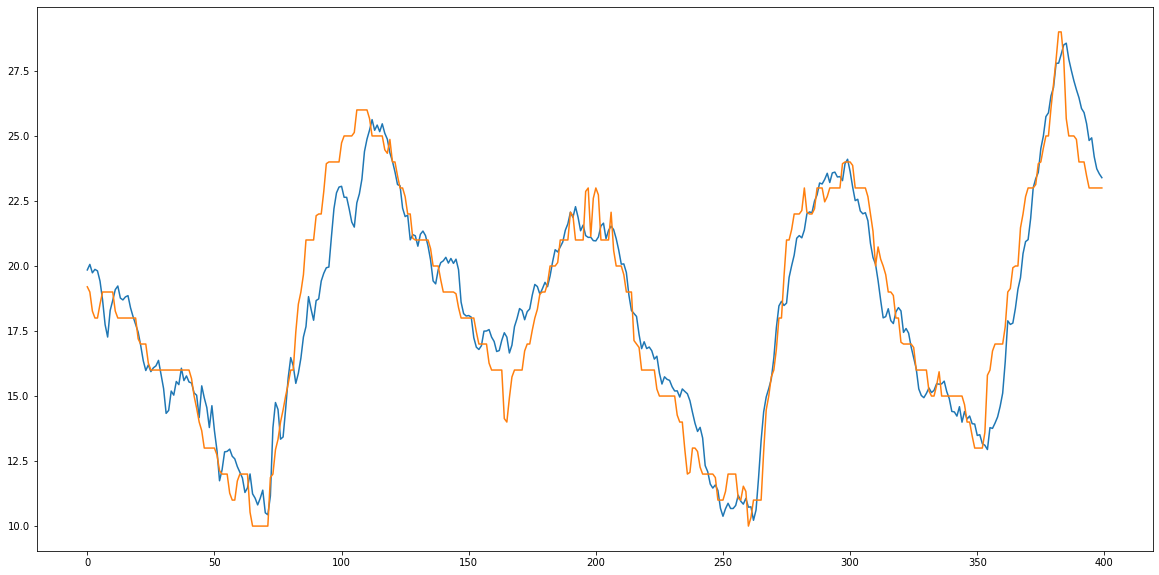

Iter:  121 train:  0.012230652591793388 val:  0.05782123190431431
Iter time:  0.556610094383359
Iter:  122 train:  0.012972745108832704 val:  0.05948748411545899
Iter time:  0.5556119931861758
Iter:  123 train:  0.011556733821976821 val:  0.058365388915288155
Iter time:  0.555416377261281
Iter:  124 train:  0.012323324154427103 val:  0.059570930040004
Iter time:  0.5560647724196315
Iter:  125 train:  0.011807997564152012 val:  0.05768330126812429
Iter time:  0.5558127602562308
Iter:  126 train:  0.010579741792882878 val:  0.060100359776843394
Iter time:  0.4675967814400792
Iter:  127 train:  0.010593119389526326 val:  0.058965515127842316
Iter time:  0.4584662616252899
Iter:  128 train:  0.010909557452284745 val:  0.06118162083606445
Iter time:  0.4636195320636034
Iter:  129 train:  0.011742762919766071 val:  0.058119571481004974
Iter time:  0.4265747657045722
Iter:  130 train:  0.011049058806468646 val:  0.05833979951124427
Iter time:  0.44266409520059824
mse:  1.6473095 mae:  0.97938

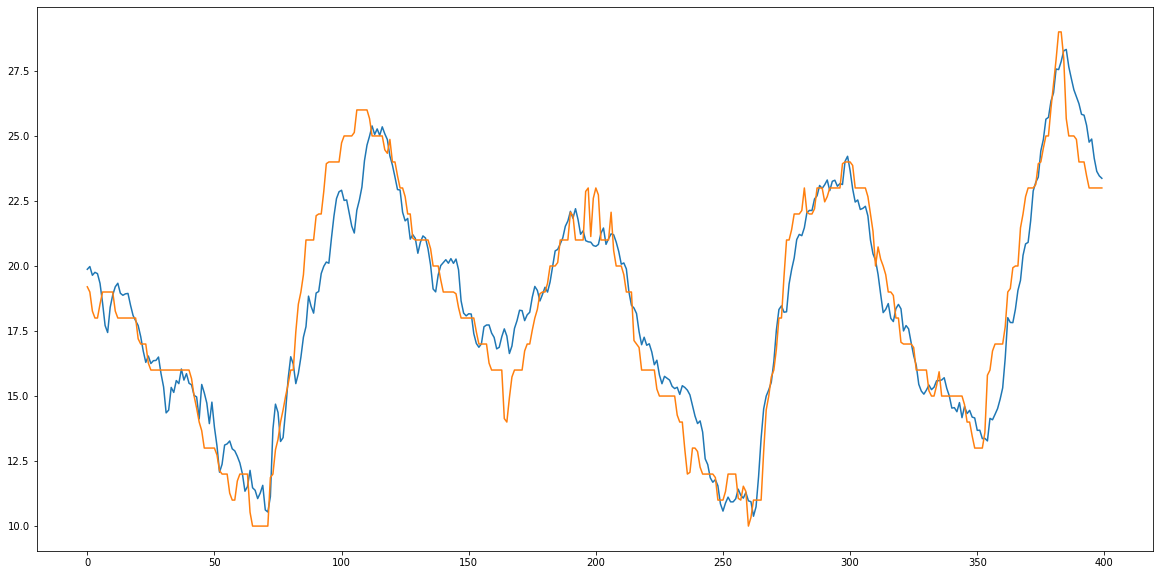

Iter:  131 train:  0.011517795489122358 val:  0.05772753025822992
Iter time:  0.44967001769691706
Iter:  132 train:  0.012095089243077572 val:  0.05796890688049804
Iter time:  0.4214137103408575
Iter:  133 train:  0.011317184338802565 val:  0.0609740816866544
Iter time:  0.46895966585725546
Iter:  134 train:  0.01422852354104854 val:  0.05892529054664367
Iter time:  0.46688179671764374
Iter:  135 train:  0.012306415868528969 val:  0.06126108544860343
Iter time:  0.45677103102207184
Iter:  136 train:  0.013300151782790636 val:  0.05816718374297343
Iter time:  0.4302674336358905
Iter:  137 train:  0.013139585437080324 val:  0.05767149031166382
Iter time:  0.43730053026229143
Iter:  138 train:  0.017735843256940855 val:  0.058872201816107916
Iter time:  0.45741171948611736
Iter:  139 train:  0.01477042884889016 val:  0.05846312999934405
Iter time:  0.4594963612034917
Iter:  140 train:  0.010584560834961735 val:  0.05809428676431122
Iter time:  0.44851176254451275
mse:  1.6334739 mae:  0.9

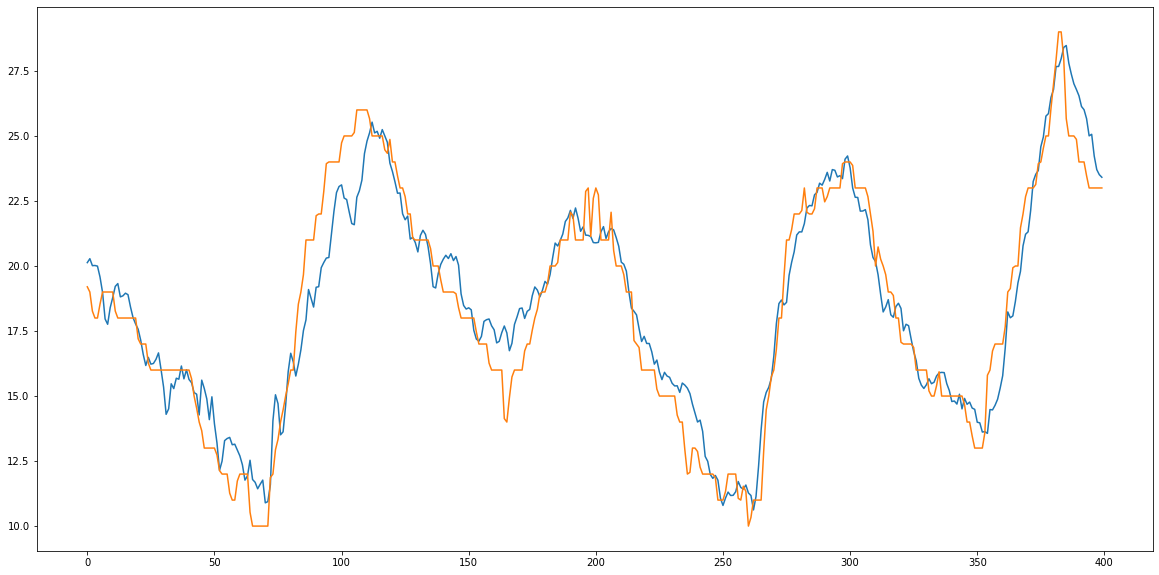

Iter:  141 train:  0.011201026377570438 val:  0.05690123421980506
Iter time:  0.46080111525952816
Iter:  142 train:  0.009691792490464661 val:  0.0587558589205282
Iter time:  0.4659965131431818
Iter:  143 train:  0.00992904802337733 val:  0.059501622260291494
Iter time:  0.42167959455400705
Iter:  144 train:  0.012910537264954093 val:  0.05926177466114985
Iter time:  0.4457464423030615
Iter:  145 train:  0.00991888477779836 val:  0.05766422097742899
Iter time:  0.45821284782141447
Iter:  146 train:  0.010396180318379316 val:  0.057985220468905745
Iter time:  0.4598342729732394
Iter:  147 train:  0.011784505876936987 val:  0.059429446936639874
Iter time:  0.4435611004009843
Iter:  148 train:  0.013033505917958635 val:  0.05793226087157197
Iter time:  0.42190028820186853
Iter:  149 train:  0.012771323580275572 val:  0.05952920652371593
Iter time:  0.4601220963522792
Iter:  150 train:  0.011948916526813094 val:  0.05984843133688782
Iter time:  0.4595839437097311
mse:  1.7336081 mae:  1.04

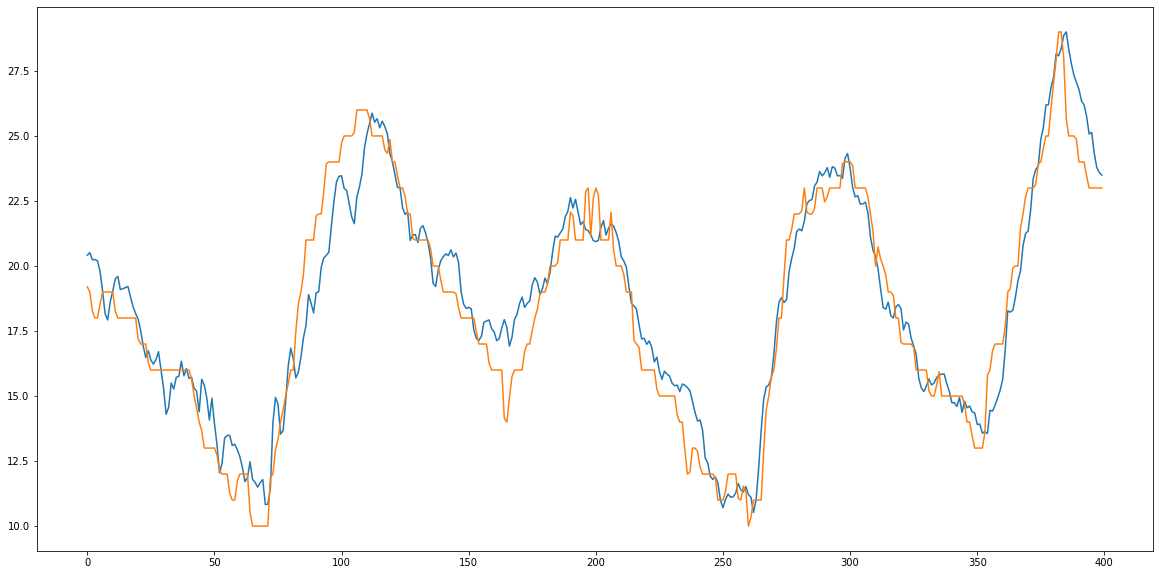

Iter:  151 train:  0.00983129500297411 val:  0.059426558532927345
Iter time:  0.45432216580957174
Iter:  152 train:  0.009945856254965945 val:  0.05845581890802931
Iter time:  0.458947011269629
Iter:  153 train:  0.01002171861946125 val:  0.05810040315618055
Iter time:  0.45837720204144716
Iter:  154 train:  0.01102579416668862 val:  0.059013637648134915
Iter time:  0.43379067443311214
Iter:  155 train:  0.009169344306404701 val:  0.05961884632084819
Iter time:  0.4325888203456998
Iter:  156 train:  0.0114984358239291 val:  0.05852283955346099
Iter time:  0.4585421411320567
Iter:  157 train:  0.011599579729234068 val:  0.057001401000937674
Iter time:  0.4601737279444933
Iter:  158 train:  0.013375093628366133 val:  0.058510696677249376
Iter time:  0.4545797500759363
Iter:  159 train:  0.011577322458648258 val:  0.0580568183658789
Iter time:  0.4201976591721177
Iter:  160 train:  0.010467677545655656 val:  0.057941126944718
Iter time:  0.452514405362308
mse:  1.6248721 mae:  0.9848454


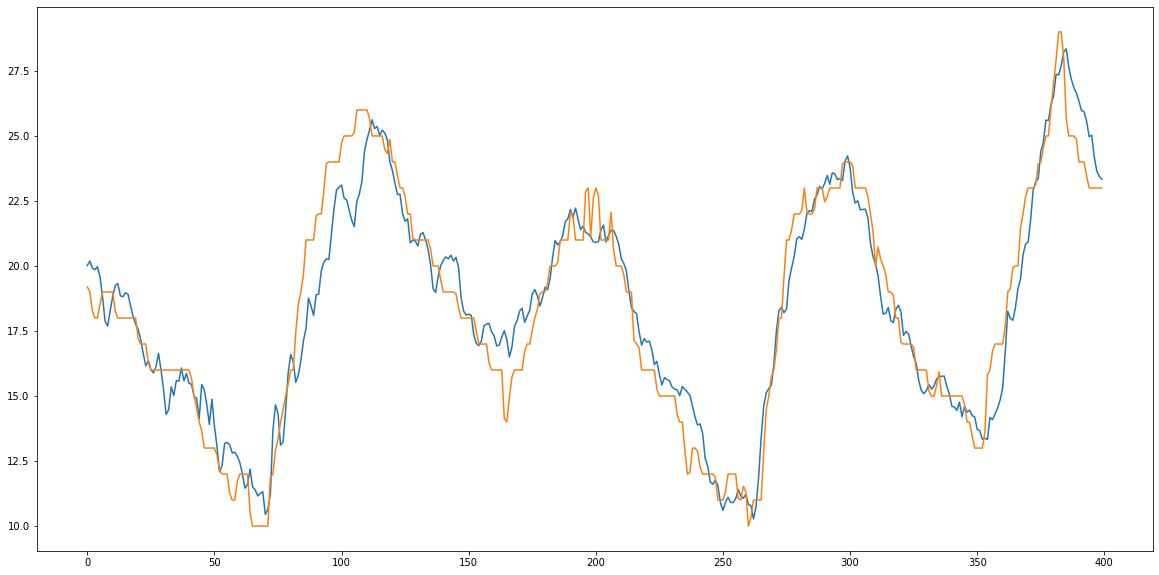

Iter:  161 train:  0.008677429464566642 val:  0.05763086997036044
Iter time:  0.4969563568010926
Iter:  162 train:  0.009314606326019506 val:  0.06186071588624392
Iter time:  0.41931809950619936
Iter:  163 train:  0.011996120976883877 val:  0.058570343110685985
Iter time:  0.46140753105282784
Iter:  164 train:  0.010655552377939172 val:  0.05963337702504566
Iter time:  0.4621001034975052
Iter:  165 train:  0.009299209962810981 val:  0.05782172348574928
Iter time:  0.4641505926847458
Iter:  166 train:  0.008513485078064362 val:  0.05845909317667686
Iter time:  0.4368317797780037
Iter:  167 train:  0.008124805109710524 val:  0.05922870242851216
Iter time:  0.4367636423557997
Iter:  168 train:  0.008959672533125003 val:  0.057841858626304844
Iter time:  0.4625517325475812
Iter:  169 train:  0.011409362851434025 val:  0.058932373037266624
Iter time:  0.46128599904477596
Iter:  170 train:  0.010291301073468801 val:  0.060304851108728894
Iter time:  0.4684527534991503
mse:  1.7601508 mae:  1

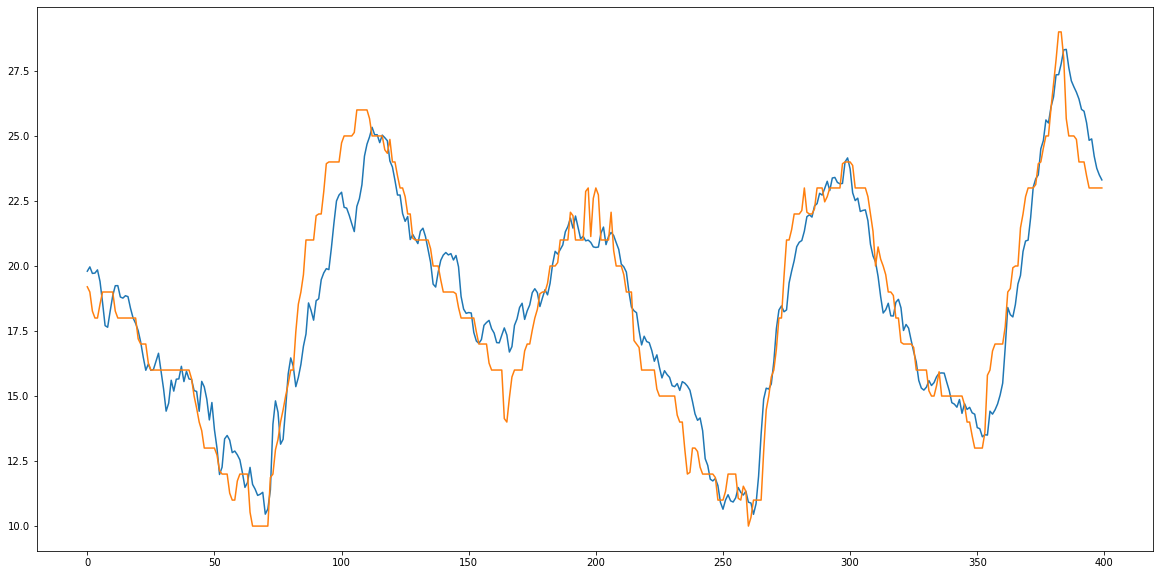

Iter:  171 train:  0.011639709649826751 val:  0.058281409337539294
Iter time:  0.46040785033255816
Iter:  172 train:  0.010892416388826329 val:  0.06020064016600606
Iter time:  0.4599586445838213
Iter:  173 train:  0.011162693951479721 val:  0.05756755598573766
Iter time:  0.4339085891842842
Iter:  174 train:  0.011364703836457343 val:  0.057580678978931855
Iter time:  0.43466242030262947
Iter:  175 train:  0.012450842978978423 val:  0.05907192837427639
Iter time:  0.4605831252411008
Iter:  176 train:  0.009686729897758942 val:  0.05907808590161014
Iter time:  0.4632562333717942
Iter:  177 train:  0.0130463874475436 val:  0.06165841071431548
Iter time:  0.4568117670714855
Iter:  178 train:  0.011700202757056398 val:  0.057511957702990155
Iter time:  0.41966638527810574
Iter:  179 train:  0.013162308858098031 val:  0.058392168110400246
Iter time:  0.45179674308747053
Iter:  180 train:  0.01040163552764066 val:  0.06142840235808067
Iter time:  0.4600820578634739
mse:  1.826349 mae:  1.08

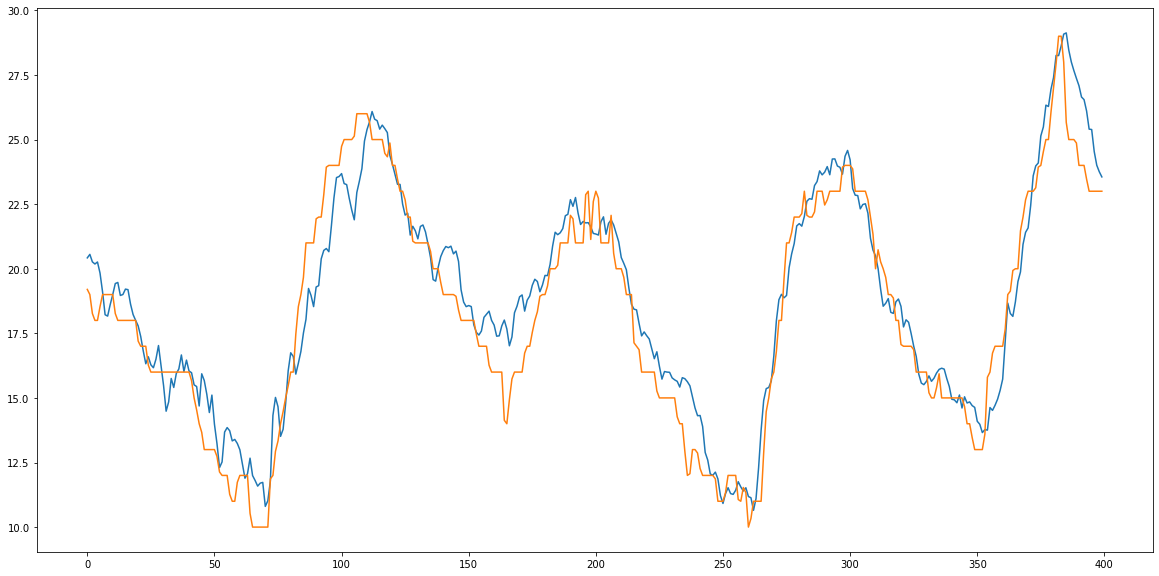

Iter:  181 train:  0.009659904730165134 val:  0.05924930899379075
Iter time:  0.4384819893166423
Iter:  182 train:  0.008846703733908483 val:  0.058342425490711516
Iter time:  0.4596289824694395
Iter:  183 train:  0.008591196295659305 val:  0.05828979043540547
Iter time:  0.4605678105726838
Iter:  184 train:  0.008099776802143997 val:  0.06017990018967224
Iter time:  0.453825400210917


In [88]:
epochs = 1000
loss = nn.MSELoss()
patience = 75
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "convrnn_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [91]:
model.load_state_dict(torch.load("convrnn_sml2010.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [94]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [95]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [96]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [97]:
mse, mae

(1.2804621, 0.9141767)

In [98]:
mse**0.5

1.1315750729869225

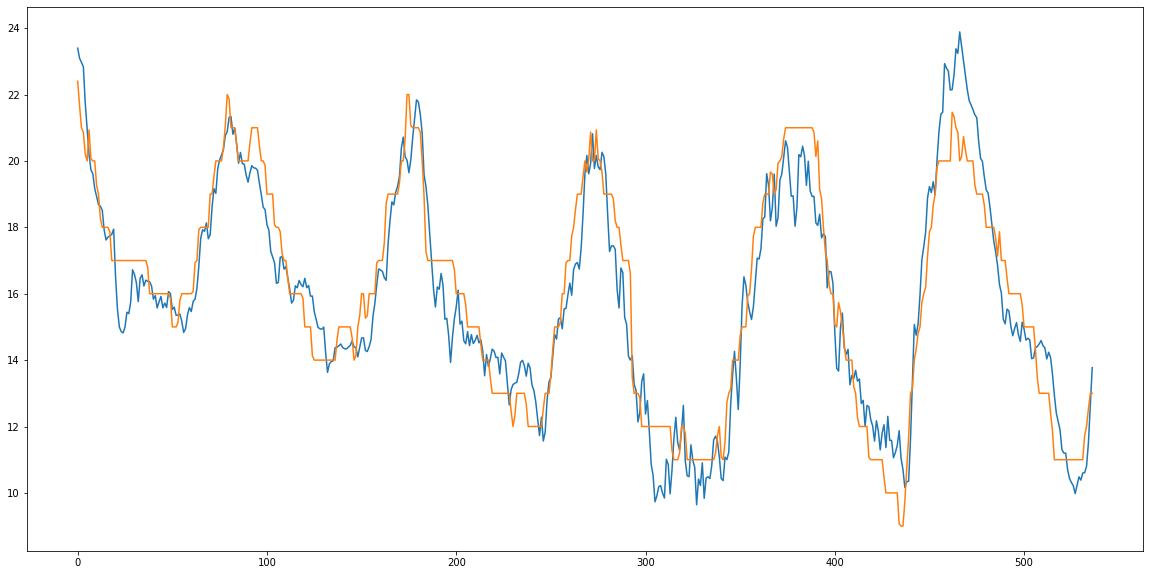

In [99]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()